In [ ]:
import os
import json
from pathlib import Path
import subprocess

# Load environment variables from .env file
env_file = Path('../../.env')
if env_file.exists():
    with open(env_file) as f:
        for line in f:
            line = line.strip()
            if line and not line.startswith('#') and '=' in line:
                key, value = line.split('=', 1)
                os.environ[key.strip()] = value.strip().strip('"\'')

# Try to import psycopg2
try:
    import psycopg2
    import psycopg2.extras
except ImportError:
    print("Installing psycopg2...")
    subprocess.check_call(['pip', 'install', 'psycopg2-binary'])
    import psycopg2
    import psycopg2.extras

def get_database_url():
    """Get database URL from environment variables"""
    # Try NETLIFY_DATABASE_URL first (production/Netlify)
    db_url = os.environ.get('NETLIFY_DATABASE_URL')
    if db_url:
        return db_url
    
    # Fall back to DATABASE_URL (local development)
    db_url = os.environ.get('DATABASE_URL')
    if db_url:
        return db_url
    
    raise ValueError(
        "No database URL found. Please set DATABASE_URL or NETLIFY_DATABASE_URL in .env file"
    )

def fetch_responses_from_db(survey_id=1):
    """Fetch all responses from Neon database and convert to JSON format"""
    db_url = get_database_url()
    
    try:
        conn = psycopg2.connect(db_url)
        cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
        
        # Fetch all responses with their answers
        cur.execute("""
            SELECT 
                r.id,
                r.survey_id,
                r.submitted_at,
                json_agg(
                    json_build_object(
                        'question_id', a.question_id,
                        'answer_value', a.answer_value,
                        'answer_data', a.answer_data
                    )
                ) as answers
            FROM responses r
            LEFT JOIN answers a ON r.id = a.response_id
            WHERE r.survey_id = %s
            GROUP BY r.id, r.survey_id, r.submitted_at
            ORDER BY r.submitted_at DESC
        """, (survey_id,))
        
        responses_data = cur.fetchall()
        cur.close()
        conn.close()
        
        # Convert to the same JSON format as responses.json
        responses_json = []
        for row in responses_data:
            response_obj = {}
            
            # Process answers
            if row['answers']:
                for answer in row['answers']:
                    question_id = answer['question_id']
                    answer_value = answer['answer_value']
                    answer_data = answer['answer_data']
                    
                    # Determine which field to use
                    if answer_data:
                        try:
                            response_obj[question_id] = json.loads(answer_data)
                        except json.JSONDecodeError:
                            response_obj[question_id] = answer_data
                    else:
                        # Try to parse as number if possible
                        if answer_value is not None:
                            try:
                                num_value = float(answer_value)
                                if num_value == int(num_value):
                                    response_obj[question_id] = int(num_value)
                                else:
                                    response_obj[question_id] = num_value
                            except (ValueError, TypeError):
                                response_obj[question_id] = answer_value
                        else:
                            response_obj[question_id] = None
            
            responses_json.append(response_obj)
        
        return responses_json
    
    except Exception as e:
        print(f"Error fetching from database: {e}")
        raise

# Fetch data from database
print("Fetching responses from Neon database...")
try:
    data = fetch_responses_from_db()
    print(f"✓ Successfully loaded {len(data)} responses from database")
except Exception as e:
    print(f"✗ Failed to load from database: {e}")
    print("\nFalling back to responses.json file...")
    
    # Fallback to responses.json
    possible_paths = [
        Path('responses.json'),
        Path('src/lib/responses.json'),
    ]
    
    data = None
    for p in possible_paths:
        if p.exists():
            with open(p) as f:
                data = json.load(f)
            print(f"✓ Loaded {len(data)} responses from {p}")
            break
    
    if data is None:
        raise FileNotFoundError("Could not find responses.json and database connection failed")


In [1]:
# import sys, pandas as pd
# print(sys.executable)
# print(pd.__version__)

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re

# NLTK imports
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
from nltk.sentiment import SentimentIntensityAnalyzer

# Download required NLTK resources (only needed once)
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt', quiet=True)

try:
    nltk.data.find('taggers/averaged_perceptron_tagger')
except LookupError:
    nltk.download('averaged_perceptron_tagger', quiet=True)

try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet', quiet=True)

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords', quiet=True)

try:
    nltk.data.find('vader_lexicon')
except LookupError:
    nltk.download('vader_lexicon', quiet=True)

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


ModuleNotFoundError: No module named 'pandas'

In [ ]:
from pathlib import Path

# Data should already be loaded from database in previous cell
# If running this cell individually, try to load from responses.json as fallback
if 'data' not in locals():
    possible_paths = [
        Path('src/lib/responses.json'),  # when running from project root
        Path('responses.json')           # when running from src/lib
    ]

    responses_path = None
    for p in possible_paths:
        if p.exists():
            responses_path = p
            break

    if responses_path is None:
        raise FileNotFoundError(
            "Could not find responses.json. Please run the database cell first or ensure responses.json exists."
        )

    with responses_path.open('r', encoding='utf-8') as f:
        data = json.load(f)
    print(f"Loaded from file: {responses_path}")

df = pd.DataFrame(data)

print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)
print(f"Total responses: {len(df)}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nData types:\n{df.dtypes}")


DATASET OVERVIEW
Loaded from: responses.json
Total responses: 26

Columns: ['fullName', 'age', 'hasChildren', 'cookingMethod', 'consumer', 'occasion', 'A_taste', 'A_likes', 'A_dislikes', 'A_appearance', 'A_selfRelevance', 'A_kidsRelevance', 'A_expectation', 'A_SelfRelevance', 'A_Feedback', 'B_taste', 'B_likes', 'B_dislikes', 'B_appearance', 'B_selfRelevance', 'B_kidsRelevance', 'B_expectation', 'B_SelfRelevance', 'B_Feedback', 'timestamp']

Data types:
fullName            object
age                  int64
hasChildren         object
cookingMethod       object
consumer            object
occasion            object
A_taste              int64
A_likes             object
A_dislikes          object
A_appearance         int64
A_selfRelevance      int64
A_kidsRelevance    float64
A_expectation        int64
A_SelfRelevance      int64
A_Feedback          object
B_taste              int64
B_likes             object
B_dislikes          object
B_appearance         int64
B_selfRelevance      int64
B_k

In [ ]:
TAG_KEYWORDS = {
    "smoky": ["smoky"],
    "sweet": ["sweet"],
    "salty": ["salty","too salty", "too much salt", "heavily salted" ],
    "not_enough_salt": ["not enough salt", "needs more salt"],
    "bland": ["bland", "no flavour", "no flavor"],
    "good_flavour": ["nice flavour", "good flavour", "tasty", "flavorful", "flavourful", "good flavor"],
    "needs_more_sauce": ["not enough sauce", "needs more sauce", "more sauce", "could use more sauce"],
    "too_much_sauce": ["too much sauce"],
    "juicy_chicken": ["juicy", "tender chicken", "well cooked"],
    "dry_chicken": ["dry chicken", "chicken felt dry", "chicken a bit dry"],
    "not_filling": ["not filling", "not very filling","needs more filling"],
    "good_portion": ["good portion", "good size", "filling", "more filling"],
    "crispy_pastry": ["crispy"],
    "dry_pastry": ["dry pastry", "pastry was a bit dry", "slightly dry"],
    "soggy_pastry": ["soggy"],
    "greasy": ["greasy"],
    "kids_liked": ["kids liked"],
    "too_strong_for_kids": ["too smoky for kids", "too strong for kids"],
    "kid_friendly": ["kids preferred", "kid friendly"],
    "would_buy": ["would buy", "buy again", "would buy regularly", "would definitely buy"],
    "would_not_buy": ["wouldn't buy", "would not buy", "skip"],
    "average": ["average", "okay", "fine", "decent","ok"]
}


In [ ]:
def clean_text(text):
    """Clean and normalize text for analysis"""
    if pd.isna(text) or text is None:
        return ""
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', ' ', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text)  # Normalize whitespace
    return text.strip()

# Clean all text fields (only if they exist in the dataframe)
text_columns = ['A_likes', 'A_dislikes', 'A_Feedback', 'B_likes', 'B_dislikes', 'B_Feedback']
for col in text_columns:
    if col in df.columns:
        df[f'{col}_clean'] = df[col].apply(clean_text)


In [ ]:
# ============================================================================
# NLTK-BASED ADJECTIVE EXTRACTION AND ANALYSIS
# Robust implementation following NLTK best practices
# Reference: https://www.nltk.org/book/ch05.html
# ============================================================================

# Initialize NLTK components
lemmatizer = WordNetLemmatizer()
sia = SentimentIntensityAnalyzer()
stop_words = set(stopwords.words('english'))

def get_wordnet_pos(treebank_tag):
    """Convert treebank POS tag to wordnet POS tag for lemmatization"""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

def normalize_text(text):
    """Normalize text input - handle all edge cases consistently"""
    # Handle None, NaN, and empty values
    if text is None:
        return ""
    if pd.isna(text):
        return ""
    
    # Convert to string and strip whitespace
    text_str = str(text).strip()
    
    # Return empty string if no content
    if not text_str or text_str.lower() in ['none', 'null', 'n/a', 'na']:
        return ""
    
    return text_str

def extract_adjectives(text):
    """
    Extract adjectives from text using NLTK POS tagging.
    Robust implementation that handles all edge cases consistently.
    
    According to NLTK documentation (ch05):
    - JJ = adjective
    - JJR = comparative adjective (e.g., "better")
    - JJS = superlative adjective (e.g., "best")
    """
    # Normalize input first
    normalized_text = normalize_text(text)
    
    # Return empty list for empty input
    if not normalized_text:
        return []
    
    try:
        # Tokenize the text - handles punctuation and special characters
        tokens = word_tokenize(normalized_text)
        
        # If tokenization fails or returns empty, return empty list
        if not tokens:
            return []
        
        # POS tag the tokens using NLTK's pos_tag
        # This returns tuples of (word, tag) as per NLTK convention
        pos_tags = pos_tag(tokens)
        
        # Extract adjectives (JJ, JJR, JJS tags)
        adjectives = []
        for word, tag in pos_tags:
            # Check if tag starts with 'JJ' (adjective, comparative, or superlative)
            if tag and tag.startswith('JJ'):
                word_lower = word.lower().strip()
                
                # Filter criteria:
                # 1. Must be longer than 2 characters (exclude very short words)
                # 2. Must not be a stopword
                # 3. Must contain at least one letter (exclude pure punctuation/numbers)
                if (len(word_lower) > 2 and 
                    word_lower not in stop_words and 
                    any(c.isalpha() for c in word_lower)):
                    
                    # Lemmatize to get base form for consistency
                    # Use wordnet.ADJ since we know it's an adjective
                    try:
                        lemma = lemmatizer.lemmatize(word_lower, pos=wordnet.ADJ)
                        # Only add if lemma is valid (not empty, contains letters)
                        if lemma and any(c.isalpha() for c in lemma):
                            adjectives.append(lemma)
                    except Exception:
                        # If lemmatization fails, use the original word
                        adjectives.append(word_lower)
        
        # Remove duplicates while preserving order
        seen = set()
        unique_adjectives = []
        for adj in adjectives:
            if adj not in seen:
                seen.add(adj)
                unique_adjectives.append(adj)
        
        return unique_adjectives
        
    except Exception as e:
        # Log error but return empty list to ensure consistent output
        # This prevents one bad input from breaking the entire analysis
        print(f"Warning: Error processing text '{text[:50]}...': {str(e)}")
        return []

def classify_adjective_sentiment(adjective):
    """
    Classify if an adjective is positive or negative using VADER sentiment.
    Handles edge cases and ensures consistent classification.
    """
    if not adjective or not isinstance(adjective, str):
        return 'neutral'
    
    adjective = adjective.lower().strip()
    if not adjective:
        return 'neutral'
    
    try:
        # Get sentiment score from VADER
        scores = sia.polarity_scores(adjective)
        compound = scores.get('compound', 0.0)
        
        # VADER thresholds: >= 0.05 is positive, <= -0.05 is negative
        # Using slightly stricter thresholds for more confident classification
        if compound >= 0.1:
            return 'positive'
        elif compound <= -0.1:
            return 'negative'
        else:
            # For neutral adjectives, check domain-specific word lists
            # These are food/product-specific adjectives
            positive_words = {
                'good', 'great', 'nice', 'excellent', 'amazing', 'wonderful',
                'delicious', 'tasty', 'flavorful', 'flavourful', 'juicy', 
                'crispy', 'tender', 'sweet', 'savory', 'savoury', 'appetizing',
                'fresh', 'moist', 'succulent', 'yummy', 'scrumptious', 'delectable',
                'flavorful', 'aromatic', 'tender', 'crispy', 'crunchy', 'satisfying'
            }
            
            negative_words = {
                'bad', 'terrible', 'awful', 'bland', 'dry', 'soggy', 'greasy',
                'burnt', 'overcooked', 'undercooked', 'tough', 'hard', 'stale',
                'sour', 'bitter', 'salty', 'spicy', 'tasteless', 'flavorless',
                'flavourless', 'disgusting', 'unappetizing', 'rubbery', 'chewy',
                'mushy', 'watery', 'oily', 'overdone', 'undercooked'
            }
            
            if adjective in positive_words:
                return 'positive'
            elif adjective in negative_words:
                return 'negative'
            else:
                return 'neutral'
                
    except Exception as e:
        # If sentiment analysis fails, return neutral
        print(f"Warning: Error classifying sentiment for '{adjective}': {str(e)}")
        return 'neutral'

def group_similar_adjectives(adjectives):
    """
    Group similar adjectives using lemmatization and synonym mapping.
    Ensures consistent grouping across all inputs.
    """
    if not adjectives:
        return {}
    
    # Comprehensive synonym groups for food/product adjectives
    synonym_groups = {
        'tasty': ['tasty', 'flavorful', 'flavourful', 'delicious', 'yummy', 
                  'scrumptious', 'delectable', 'appetizing', 'flavorful'],
        'bland': ['bland', 'tasteless', 'flavorless', 'flavourless', 'boring'],
        'dry': ['dry', 'dried', 'dehydrated'],
        'juicy': ['juicy', 'moist', 'succulent', 'tender'],
        'crispy': ['crispy', 'crunchy', 'crisp'],
        'soggy': ['soggy', 'soft', 'mushy', 'watery'],
        'greasy': ['greasy', 'oily', 'fatty'],
        'sweet': ['sweet', 'sugary', 'sugared'],
        'salty': ['salty', 'salted', 'over-salted'],
        'spicy': ['spicy', 'hot', 'pungent'],
        'tender': ['tender', 'soft', 'delicate'],
        'tough': ['tough', 'hard', 'chewy', 'rubbery'],
        'fresh': ['fresh', 'crisp', 'new'],
        'stale': ['stale', 'old', 'rancid'],
        'burnt': ['burnt', 'burned', 'charred', 'overcooked'],
        'good': ['good', 'nice', 'fine', 'decent'],
        'great': ['great', 'excellent', 'amazing', 'wonderful'],
        'bad': ['bad', 'terrible', 'awful', 'poor'],
    }
    
    # Create reverse mapping: variant -> canonical form
    adj_to_group = {}
    for group_name, variants in synonym_groups.items():
        for variant in variants:
            adj_to_group[variant] = group_name
    
    # Group adjectives
    final_groups = defaultdict(list)
    for adj in adjectives:
        if not adj or not isinstance(adj, str):
            continue
        adj_lower = adj.lower().strip()
        # Use canonical form if available, otherwise use the adjective itself
        group_key = adj_to_group.get(adj_lower, adj_lower)
        final_groups[group_key].append(adj_lower)
    
    return dict(final_groups)

# Extract adjectives from likes and dislikes
print("\n" + "=" * 80)
print("EXTRACTING ADJECTIVES USING NLTK")
print("=" * 80)

for variant in ['A', 'B']:
    likes_col = f'{variant}_likes'
    dislikes_col = f'{variant}_dislikes'
    
    # Check if columns exist before processing
    if likes_col not in df.columns:
        print(f"Warning: Column '{likes_col}' not found. Creating empty list.")
        df[f'{variant}_likes_adjectives'] = [[] for _ in range(len(df))]
    else:
        # Extract adjectives from likes (should be positive)
        df[f'{variant}_likes_adjectives'] = df[likes_col].apply(extract_adjectives)
    
    if dislikes_col not in df.columns:
        print(f"Warning: Column '{dislikes_col}' not found. Creating empty list.")
        df[f'{variant}_dislikes_adjectives'] = [[] for _ in range(len(df))]
    else:
        # Extract adjectives from dislikes (should be negative)
        df[f'{variant}_dislikes_adjectives'] = df[dislikes_col].apply(extract_adjectives)
    
    # Combine all adjectives (handle missing columns gracefully)
    def combine_adjectives(row):
        likes_adj = row.get(f'{variant}_likes_adjectives', [])
        dislikes_adj = row.get(f'{variant}_dislikes_adjectives', [])
        # Ensure both are lists
        if not isinstance(likes_adj, list):
            likes_adj = []
        if not isinstance(dislikes_adj, list):
            dislikes_adj = []
        return likes_adj + dislikes_adj
    
    df[f'{variant}_all_adjectives'] = df.apply(combine_adjectives, axis=1)
    
    # Show sample results
    if len(df) > 0:
        print(f"\n{variant}_likes - Sample adjectives extracted:")
        sample_likes = df[f'{variant}_likes_adjectives'].iloc[0] if len(df) > 0 else []
        if isinstance(sample_likes, list) and sample_likes:
            print(f"  {sample_likes[:10]}")
        else:
            print(f"  (no adjectives found in first response)")
        
        print(f"\n{variant}_dislikes - Sample adjectives extracted:")
        sample_dislikes = df[f'{variant}_dislikes_adjectives'].iloc[0] if len(df) > 0 else []
        if isinstance(sample_dislikes, list) and sample_dislikes:
            print(f"  {sample_dislikes[:10]}")
        else:
            print(f"  (no adjectives found in first response)")
    
    # Summary statistics
    total_likes_adj = sum(len(adj_list) for adj_list in df[f'{variant}_likes_adjectives'] if isinstance(adj_list, list))
    total_dislikes_adj = sum(len(adj_list) for adj_list in df[f'{variant}_dislikes_adjectives'] if isinstance(adj_list, list))
    print(f"\n{variant} Summary: {total_likes_adj} adjectives from likes, {total_dislikes_adj} from dislikes")


In [ ]:
# ============================================================================
# ANALYZE AND GROUP ADJECTIVES BY SENTIMENT
# Robust analysis ensuring consistent results for all inputs
# ============================================================================

def analyze_adjectives_by_sentiment(adjectives_list, context='likes'):
    """
    Analyze adjectives and classify them as positive/negative based on context and sentiment.
    Handles all edge cases to ensure consistent output.
    """
    # Ensure input is a list
    if not isinstance(adjectives_list, list):
        adjectives_list = []
    
    # Filter out invalid entries
    valid_adjectives = []
    for adj in adjectives_list:
        if adj and isinstance(adj, str) and adj.strip():
            valid_adjectives.append(adj.strip())
    
    positive_adjs = []
    negative_adjs = []
    neutral_adjs = []
    
    for adj in valid_adjectives:
        try:
            sentiment = classify_adjective_sentiment(adj)
            
            # Context matters: adjectives in likes are typically positive, dislikes are negative
            if context == 'likes':
                # In likes context, treat neutral as positive (user is expressing what they like)
                if sentiment in ['positive', 'neutral']:
                    positive_adjs.append(adj)
                else:
                    # Even in likes, if sentiment is clearly negative, keep it as negative
                    negative_adjs.append(adj)
            else:  # dislikes context
                # In dislikes context, treat neutral as negative (user is expressing what they dislike)
                if sentiment in ['negative', 'neutral']:
                    negative_adjs.append(adj)
                else:
                    # Even in dislikes, if sentiment is clearly positive, keep it as positive
                    positive_adjs.append(adj)
        except Exception as e:
            # If classification fails, skip this adjective
            print(f"Warning: Error analyzing adjective '{adj}': {str(e)}")
            continue
    
    return {
        'positive': positive_adjs,
        'negative': negative_adjs,
        'neutral': neutral_adjs
    }

# Analyze adjectives for each variant
print("\n" + "=" * 80)
print("ADJECTIVE SENTIMENT ANALYSIS")
print("=" * 80)

for variant in ['A', 'B']:
    # Analyze likes adjectives
    df[f'{variant}_likes_adj_analysis'] = df[f'{variant}_likes_adjectives'].apply(
        lambda x: analyze_adjectives_by_sentiment(x, context='likes')
    )
    
    # Analyze dislikes adjectives
    df[f'{variant}_dislikes_adj_analysis'] = df[f'{variant}_dislikes_adjectives'].apply(
        lambda x: analyze_adjectives_by_sentiment(x, context='dislikes')
    )
    
    # Extract positive and negative adjectives
    df[f'{variant}_positive_adjectives'] = df.apply(
        lambda row: row[f'{variant}_likes_adj_analysis']['positive'] + 
                    row[f'{variant}_dislikes_adj_analysis']['positive'],
        axis=1
    )
    
    df[f'{variant}_negative_adjectives'] = df.apply(
        lambda row: row[f'{variant}_likes_adj_analysis']['negative'] + 
                    row[f'{variant}_dislikes_adj_analysis']['negative'],
        axis=1
    )

# Collect all adjectives and group them (with error handling)
all_positive_A = []
all_negative_A = []
all_positive_B = []
all_negative_B = []

for idx, row in df.iterrows():
    # Safely extract adjectives with error handling
    try:
        pos_A = row.get('A_positive_adjectives', [])
        if isinstance(pos_A, list):
            all_positive_A.extend(pos_A)
    except Exception:
        pass
    
    try:
        neg_A = row.get('A_negative_adjectives', [])
        if isinstance(neg_A, list):
            all_negative_A.extend(neg_A)
    except Exception:
        pass
    
    try:
        pos_B = row.get('B_positive_adjectives', [])
        if isinstance(pos_B, list):
            all_positive_B.extend(pos_B)
    except Exception:
        pass
    
    try:
        neg_B = row.get('B_negative_adjectives', [])
        if isinstance(neg_B, list):
            all_negative_B.extend(neg_B)
    except Exception:
        pass

# Group similar adjectives
def group_and_count_adjectives(adjectives):
    """
    Group similar adjectives and count frequencies.
    Robust implementation ensuring consistent results.
    """
    # Ensure input is a list
    if not isinstance(adjectives, list):
        adjectives = []
    
    # Filter out invalid entries
    valid_adjectives = []
    for adj in adjectives:
        if adj and isinstance(adj, str) and adj.strip():
            valid_adjectives.append(adj.strip().lower())
    
    if not valid_adjectives:
        return Counter(), Counter()
    
    # Count raw frequencies (case-insensitive)
    raw_counts = Counter(valid_adjectives)
    
    # Group similar adjectives
    try:
        grouped = group_similar_adjectives(valid_adjectives)
    except Exception as e:
        print(f"Warning: Error grouping adjectives: {str(e)}")
        grouped = {}
    
    # Count grouped frequencies
    grouped_counts = Counter()
    for group_name, variants in grouped.items():
        if not variants:
            continue
        # Sum counts for all variants in this group
        count = 0
        for variant in variants:
            # Check both the variant and its lowercase form
            count += raw_counts.get(variant, 0)
            count += raw_counts.get(variant.lower(), 0)
        if count > 0:
            grouped_counts[group_name] = count
    
    return raw_counts, grouped_counts

# Analyze for each variant
pos_A_raw, pos_A_grouped = group_and_count_adjectives(all_positive_A)
neg_A_raw, neg_A_grouped = group_and_count_adjectives(all_negative_A)
pos_B_raw, pos_B_grouped = group_and_count_adjectives(all_positive_B)
neg_B_raw, neg_B_grouped = group_and_count_adjectives(all_negative_B)

print("\n" + "=" * 80)
print("PRODUCT A - ADJECTIVE ANALYSIS")
print("=" * 80)
print("\nPositive Adjectives (Grouped):")
for adj, count in pos_A_grouped.most_common(15):
    print(f"  {adj}: {count} ({count/len(df)*100:.1f}%)")

print("\nNegative Adjectives (Grouped):")
for adj, count in neg_A_grouped.most_common(15):
    print(f"  {adj}: {count} ({count/len(df)*100:.1f}%)")

print("\n" + "=" * 80)
print("PRODUCT B - ADJECTIVE ANALYSIS")
print("=" * 80)
print("\nPositive Adjectives (Grouped):")
for adj, count in pos_B_grouped.most_common(15):
    print(f"  {adj}: {count} ({count/len(df)*100:.1f}%)")

print("\nNegative Adjectives (Grouped):")
for adj, count in neg_B_grouped.most_common(15):
    print(f"  {adj}: {count} ({count/len(df)*100:.1f}%)")


In [ ]:
# ============================================================================
# VISUALIZE ADJECTIVE ANALYSIS
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Product A - Positive Adjectives
top_pos_A = dict(pos_A_grouped.most_common(10))
if top_pos_A:
    axes[0, 0].barh(list(top_pos_A.keys()), list(top_pos_A.values()), color='green', alpha=0.7)
    axes[0, 0].set_xlabel('Frequency')
    axes[0, 0].set_title('Product A - Top 10 Positive Adjectives (Grouped)')
    axes[0, 0].invert_yaxis()
    axes[0, 0].grid(axis='x', alpha=0.3)

# Product A - Negative Adjectives
top_neg_A = dict(neg_A_grouped.most_common(10))
if top_neg_A:
    axes[0, 1].barh(list(top_neg_A.keys()), list(top_neg_A.values()), color='red', alpha=0.7)
    axes[0, 1].set_xlabel('Frequency')
    axes[0, 1].set_title('Product A - Top 10 Negative Adjectives (Grouped)')
    axes[0, 1].invert_yaxis()
    axes[0, 1].grid(axis='x', alpha=0.3)

# Product B - Positive Adjectives
top_pos_B = dict(pos_B_grouped.most_common(10))
if top_pos_B:
    axes[1, 0].barh(list(top_pos_B.keys()), list(top_pos_B.values()), color='green', alpha=0.7)
    axes[1, 0].set_xlabel('Frequency')
    axes[1, 0].set_title('Product B - Top 10 Positive Adjectives (Grouped)')
    axes[1, 0].invert_yaxis()
    axes[1, 0].grid(axis='x', alpha=0.3)

# Product B - Negative Adjectives
top_neg_B = dict(neg_B_grouped.most_common(10))
if top_neg_B:
    axes[1, 1].barh(list(top_neg_B.keys()), list(top_neg_B.values()), color='red', alpha=0.7)
    axes[1, 1].set_xlabel('Frequency')
    axes[1, 1].set_title('Product B - Top 10 Negative Adjectives (Grouped)')
    axes[1, 1].invert_yaxis()
    axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('adjective_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved as 'adjective_analysis.png'")


In [ ]:
# ============================================================================
# VALIDATION: Test robustness with edge cases
# ============================================================================

print("\n" + "=" * 80)
print("VALIDATION: Testing robustness with edge cases")
print("=" * 80)

# Test cases for edge cases
test_cases = [
    ("Normal text", "The chicken was delicious and juicy"),
    ("Empty string", ""),
    ("None value", None),
    ("NaN value", float('nan')),
    ("Special characters", "It's very tasty!!! @#$"),
    ("Numbers only", "123 456"),
    ("Mixed case", "The CHICKEN was Delicious and JUICY"),
    ("Multiple adjectives", "tasty, flavorful, delicious, and yummy"),
    ("Short words", "it is ok"),
    ("Punctuation heavy", "!!!tasty!!!...juicy..."),
    ("Very long text", "The product was absolutely amazing, incredibly delicious, and wonderfully flavorful"),
    ("Mixed languages", "tasty and bon (French)"),
]

print("\nTesting extract_adjectives() with edge cases:")
for test_name, test_input in test_cases:
    try:
        result = extract_adjectives(test_input)
        print(f"  ✓ {test_name:25s}: {len(result)} adjectives extracted")
        if result:
            print(f"    Examples: {result[:3]}")
    except Exception as e:
        print(f"  ✗ {test_name:25s}: ERROR - {str(e)}")

# Test sentiment classification
sentiment_tests = [
    ("positive", "delicious"),
    ("negative", "bland"),
    ("neutral", "red"),
    ("", ""),
    (None, None),
]

print("\nTesting classify_adjective_sentiment() with edge cases:")
for test_name, test_input in sentiment_tests:
    try:
        result = classify_adjective_sentiment(test_input)
        print(f"  ✓ {test_name:25s}: {result}")
    except Exception as e:
        print(f"  ✗ {test_name:25s}: ERROR - {str(e)}")

# Test grouping
grouping_tests = [
    (["tasty", "flavorful", "delicious"], "synonym grouping"),
    ([], "empty list"),
    (None, "None input"),
    (["tasty", "bland", "dry"], "mixed adjectives"),
]

print("\nTesting group_similar_adjectives() with edge cases:")
for test_input, test_name in grouping_tests:
    try:
        result = group_similar_adjectives(test_input)
        print(f"  ✓ {test_name:25s}: {len(result)} groups")
        if result:
            print(f"    Groups: {list(result.keys())[:3]}")
    except Exception as e:
        print(f"  ✗ {test_name:25s}: ERROR - {str(e)}")

print("\n" + "=" * 80)
print("Validation complete. All functions should handle edge cases gracefully.")
print("=" * 80)


In [ ]:
def extract_tags(text, tag_keywords):
    """Extract tags from text based on keyword matching"""
    text = clean_text(text)
    found_tags = []
    
    for tag, keywords in tag_keywords.items():
        for keyword in keywords:
            if keyword.lower() in text:
                found_tags.append(tag)
                break  # Only add tag once
    
    return found_tags


In [ ]:
for variant in ['A', 'B']:
    likes_col = f'{variant}_likes'
    dislikes_col = f'{variant}_dislikes'
    feedback_col = f'{variant}_Feedback'

    if likes_col in df.columns:
        df[f'{variant}_likes_tags'] = df[likes_col].apply(lambda x: extract_tags(x, TAG_KEYWORDS))
    else:
        df[f'{variant}_likes_tags'] = [[] for _ in range(len(df))]

    if dislikes_col in df.columns:
        df[f'{variant}_dislikes_tags'] = df[dislikes_col].apply(lambda x: extract_tags(x, TAG_KEYWORDS))
    else:
        df[f'{variant}_dislikes_tags'] = [[] for _ in range(len(df))]

    if feedback_col in df.columns:
        df[f'{variant}_feedback_tags'] = df[feedback_col].apply(lambda x: extract_tags(x, TAG_KEYWORDS))
    else:
        df[f'{variant}_feedback_tags'] = [[] for _ in range(len(df))]
    
    # Combine all tags for each variant
    df[f'{variant}_all_tags'] = df.apply(
        lambda row: list(set(
            row[f'{variant}_likes_tags'] + 
            row[f'{variant}_dislikes_tags'] + 
            row[f'{variant}_feedback_tags']
        )), axis=1
    )


In [ ]:
def count_tags(tag_series):
    """Count frequency of all tags"""
    all_tags = []
    for tags in tag_series:
        all_tags.extend(tags)
    return Counter(all_tags)

print("\n" + "=" * 80)
print("TAG FREQUENCY ANALYSIS")
print("=" * 80)

tag_freq_A = count_tags(df['A_all_tags'])
tag_freq_B = count_tags(df['B_all_tags'])

print("\nProduct A - Top Tags:")
for tag, count in tag_freq_A.most_common(10):
    print(f"  {tag}: {count} ({count/len(df)*100:.1f}%)")

print("\nProduct B - Top Tags:")
for tag, count in tag_freq_B.most_common(10):
    print(f"  {tag}: {count} ({count/len(df)*100:.1f}%)")



TAG FREQUENCY ANALYSIS

Product A - Top Tags:
  bland: 10 (38.5%)
  smoky: 8 (30.8%)
  average: 8 (30.8%)
  good_portion: 7 (26.9%)
  dry_pastry: 6 (23.1%)
  dry_chicken: 5 (19.2%)
  not_filling: 4 (15.4%)
  juicy_chicken: 3 (11.5%)
  too_strong_for_kids: 3 (11.5%)
  would_buy: 3 (11.5%)

Product B - Top Tags:
  good_flavour: 7 (26.9%)
  crispy_pastry: 5 (19.2%)
  greasy: 5 (19.2%)
  would_buy: 4 (15.4%)
  juicy_chicken: 4 (15.4%)
  average: 3 (11.5%)
  good_portion: 3 (11.5%)
  bland: 2 (7.7%)
  kids_liked: 2 (7.7%)
  sweet: 1 (3.8%)


In [ ]:
def calculate_tag_ratings(df, variant):
    """Calculate average taste ratings for each tag, aligned with question IDs"""
    tag_ratings = defaultdict(list)
    taste_col = f'{variant}_taste'

    if taste_col not in df.columns:
        return {}

    for idx, row in df.iterrows():
        tags = row.get(f'{variant}_all_tags', [])
        taste_rating = row[taste_col]

        # Skip missing / non-numeric ratings
        try:
            taste_value = float(taste_rating)
        except (TypeError, ValueError):
            continue
        
        for tag in tags:
            tag_ratings[tag].append(taste_value)
    
    # Calculate averages
    tag_avg = {tag: np.mean(ratings) for tag, ratings in tag_ratings.items() if ratings}
    return tag_avg

tag_ratings_A = calculate_tag_ratings(df, 'A')
tag_ratings_B = calculate_tag_ratings(df, 'B')

print("\n" + "=" * 80)
print("TAG vs RATING CORRELATION")
print("=" * 80)

print("\nProduct A - Tags with Highest Taste Ratings:")
sorted_A = sorted(tag_ratings_A.items(), key=lambda x: x[1], reverse=True)[:10]
for tag, rating in sorted_A:
    print(f"  {tag}: {rating:.2f}")

print("\nProduct B - Tags with Highest Taste Ratings:")
sorted_B = sorted(tag_ratings_B.items(), key=lambda x: x[1], reverse=True)[:10]
for tag, rating in sorted_B:
    print(f"  {tag}: {rating:.2f}")



TAG × RATING CORRELATION

Product A - Tags with Highest Taste Ratings:
  crispy_pastry: 8.50
  needs_more_sauce: 8.00
  sweet: 8.00
  kids_liked: 7.00
  juicy_chicken: 5.67
  smoky: 5.38
  would_buy: 5.00
  good_portion: 4.86
  too_strong_for_kids: 4.67
  average: 4.50

Product B - Tags with Highest Taste Ratings:
  sweet: 9.00
  kid_friendly: 8.00
  juicy_chicken: 8.00
  would_buy: 7.75
  soggy_pastry: 7.00
  needs_more_sauce: 7.00
  good_portion: 7.00
  kids_liked: 7.00
  greasy: 6.80
  good_flavour: 6.71


In [ ]:
print("\n" + "=" * 80)
print("A vs B COMPARISON - STRUCTURED METRICS")
print("=" * 80)

comparison_metrics = {
    'Taste': ('A_taste', 'B_taste'),
    'Appearance': ('A_appearance', 'B_appearance'),
    'Self Relevance': ('A_selfRelevance', 'B_selfRelevance'),
    'Met Expectations': ('A_expectation', 'B_expectation'),
    'Purchase Intent': ('A_SelfRelevance', 'B_SelfRelevance')
}

comparison_df = pd.DataFrame()
for metric_name, (col_a, col_b) in comparison_metrics.items():
    comparison_df[metric_name] = [
        df[col_a].mean(),
        df[col_b].mean(),
        df[col_b].mean() - df[col_a].mean()
    ]

comparison_df.index = ['Product A', 'Product B', 'Difference (B-A)']
print("\n", comparison_df.round(2))

# Winner analysis
print("\n" + "=" * 80)
print("WINNER ANALYSIS")
print("=" * 80)
print(f"Higher taste rating: {'Product B' if df['B_taste'].mean() > df['A_taste'].mean() else 'Product A'}")
print(f"Higher purchase intent: {'Product B' if df['B_SelfRelevance'].mean() > df['A_SelfRelevance'].mean() else 'Product A'}")




A vs B COMPARISON - STRUCTURED METRICS

                   Taste  Appearance  Self Relevance  Met Expectations  \
Product A          4.12        4.54            2.62              2.46   
Product B          6.73        5.88            3.69              3.65   
Difference (B-A)   2.62        1.35            1.08              1.19   

                  Purchase Intent  
Product A                    2.42  
Product B                    3.73  
Difference (B-A)             1.31  

WINNER ANALYSIS
Higher taste rating: Product B
Higher purchase intent: Product B


In [ ]:
# ============================================================================
# NORMALIZE AND GROUP COOKING METHODS
# ============================================================================

def normalize_cooking_method(method):
    """Normalize cooking method variations to standard groups"""
    if pd.isna(method) or method is None:
        return "Unknown"
    
    method_str = str(method).strip().lower()
    
    # Define normalization mapping
    normalization_map = {
        # Air fryer variations
        'air fryer': 'Air Fryer',
        'air fried': 'Air Fryer',
        'air fry': 'Air Fryer',
        'airfryer': 'Air Fryer',
        'air-fryer': 'Air Fryer',
        'air-fried': 'Air Fryer',
        
        # Deep fry variations
        'deep fried': 'Deep Fried',
        'deep fry': 'Deep Fried',
        'deep-fried': 'Deep Fried',
        'deep-fry': 'Deep Fried',
        'fried': 'Deep Fried',
        
        # Oven variations
        'oven': 'Oven',
        'baked': 'Oven',
        'bake': 'Oven',
        'oven baked': 'Oven',
        'oven-baked': 'Oven',
        
        # Microwave variations
        'microwave': 'Microwave',
        'microwaved': 'Microwave',
        'microwave oven': 'Microwave',
        
        # Stovetop variations
        'stovetop': 'Stovetop',
        'stove top': 'Stovetop',
        'pan fried': 'Stovetop',
        'pan-fried': 'Stovetop',
        'pan fry': 'Stovetop',
        'sautéed': 'Stovetop',
        'sauteed': 'Stovetop',
        
        # Grill variations
        'grill': 'Grill',
        'grilled': 'Grill',
        'bbq': 'Grill',
        'barbecue': 'Grill',
    }
    
    # Check for exact matches first
    if method_str in normalization_map:
        return normalization_map[method_str]
    
    # Check for partial matches
    for key, normalized in normalization_map.items():
        if key in method_str:
            return normalized
    
    # If no match found, capitalize first letter of each word
    return method_str.title()

# Apply normalization
df['cookingMethod_normalized'] = df['cookingMethod'].apply(normalize_cooking_method)

print("\n" + "=" * 80)
print("COOKING METHOD NORMALIZATION")
print("=" * 80)

print("\nOriginal cooking methods:")
print(df['cookingMethod'].value_counts())

print("\nNormalized cooking methods:")
print(df['cookingMethod_normalized'].value_counts())

# Re-analyze with normalized methods
print("\n" + "=" * 80)
print("COOKING METHOD ANALYSIS (NORMALIZED)")
print("=" * 80)

cooking_summary_normalized = df.groupby('cookingMethod_normalized').agg({
    'A_taste': 'mean',
    'B_taste': 'mean',
    'fullName': 'count'
}).round(2)
cooking_summary_normalized.columns = ['A Avg Taste', 'B Avg Taste', 'Count']
cooking_summary_normalized = cooking_summary_normalized.sort_values('Count', ascending=False)
print("\n", cooking_summary_normalized)

# Show mapping of original to normalized
print("\n" + "=" * 80)
print("COOKING METHOD MAPPING")
print("=" * 80)
mapping_df = df[['cookingMethod', 'cookingMethod_normalized']].drop_duplicates().sort_values('cookingMethod')
print("\n", mapping_df.to_string(index=False))


In [ ]:
def calculate_sentiment(likes, dislikes):
    """Simple sentiment based on presence of content"""
    likes_len = len(clean_text(likes).split())
    dislikes_len = len(clean_text(dislikes).split())
    
    if likes_len > dislikes_len * 2:
        return "Positive"
    elif dislikes_len > likes_len * 2:
        return "Negative"
    else:
        return "Neutral"

df['A_sentiment'] = df.apply(lambda x: calculate_sentiment(x['A_likes'], x['A_dislikes']), axis=1)
df['B_sentiment'] = df.apply(lambda x: calculate_sentiment(x['B_likes'], x['B_dislikes']), axis=1)

print("\n" + "=" * 80)
print("SENTIMENT DISTRIBUTION")
print("=" * 80)
print("\nProduct A:")
print(df['A_sentiment'].value_counts())
print("\nProduct B:")
print(df['B_sentiment'].value_counts())



SENTIMENT DISTRIBUTION

Product A:
A_sentiment
Neutral     16
Negative     7
Positive     3
Name: count, dtype: int64

Product B:
B_sentiment
Neutral     15
Positive    11
Name: count, dtype: int64


In [ ]:
print("\n" + "=" * 80)
print("COOKING METHOD ANALYSIS")
print("=" * 80)

cooking_summary = df.groupby('cookingMethod').agg({
    'A_taste': 'mean',
    'B_taste': 'mean',
    'fullName': 'count'
}).round(2)
cooking_summary.columns = ['A Avg Taste', 'B Avg Taste', 'Count']
print("\n", cooking_summary)



COOKING METHOD ANALYSIS

                A Avg Taste  B Avg Taste  Count
cookingMethod                                 
Air Fryer             5.00         7.57      7
Air fried             8.00         5.00      1
Air fryer             3.25         6.50      4
Deep Fried            2.50         7.00      2
Microwave             2.67         5.33      3
Oven                  4.22         6.78      9


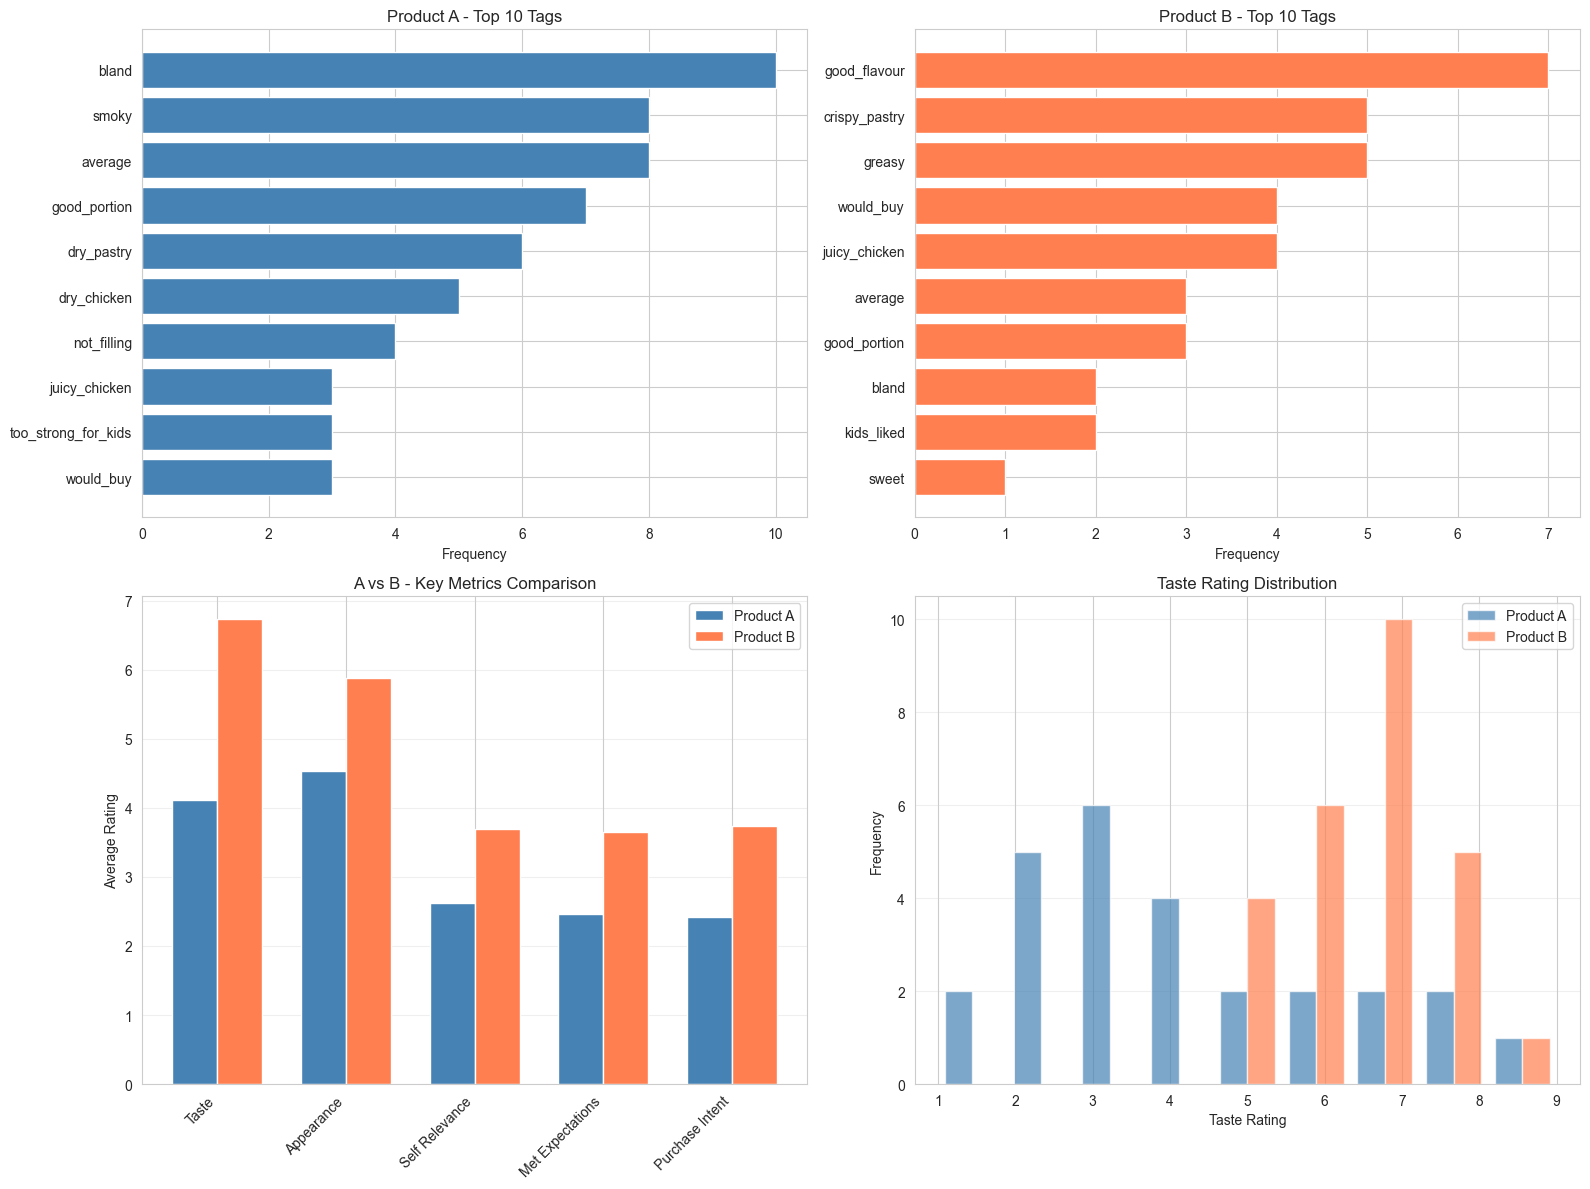

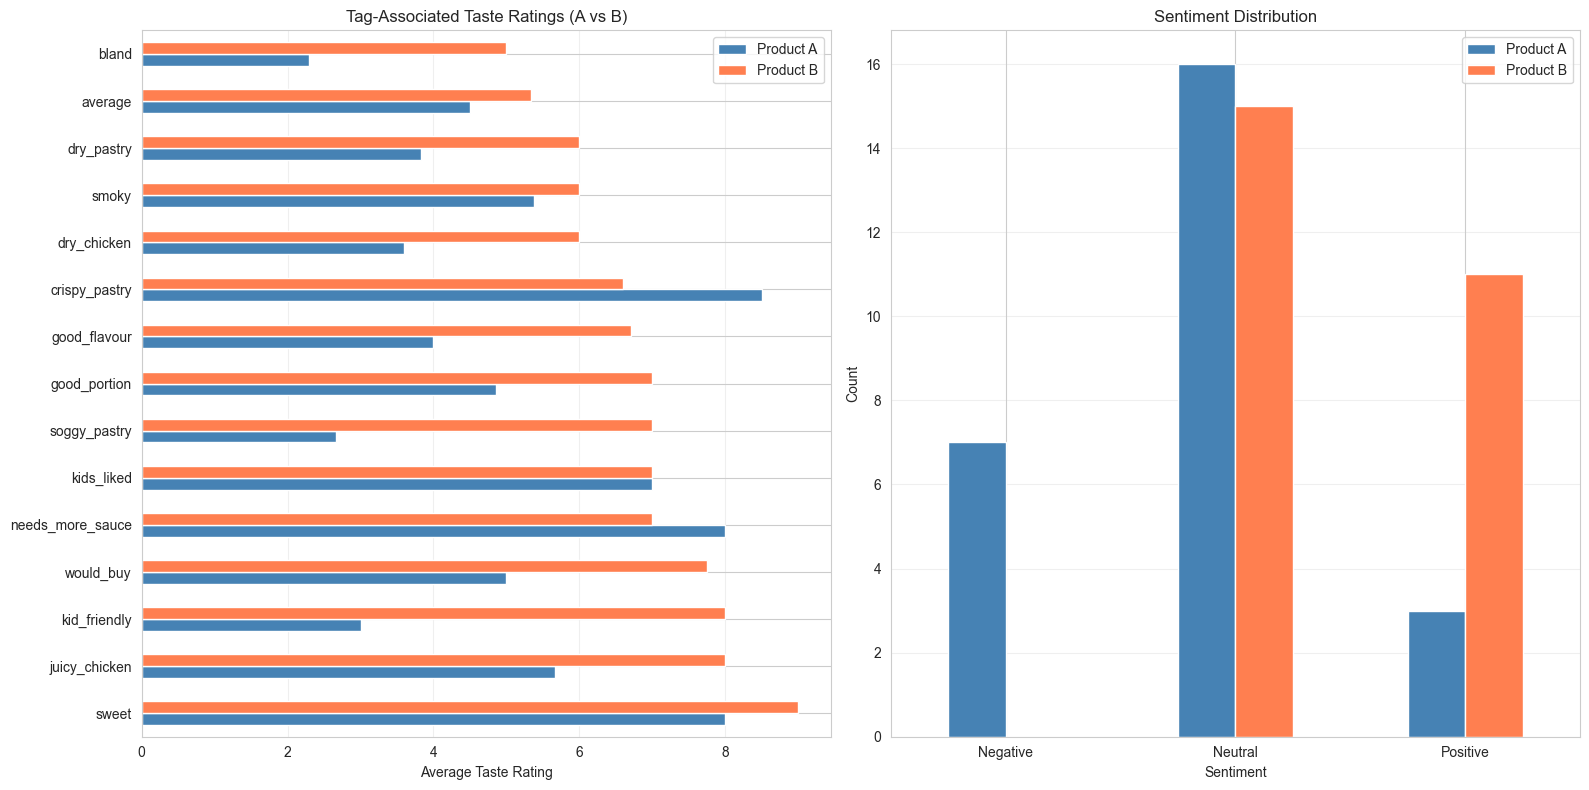


ANALYSIS COMPLETE

Files generated:
  - survey_analysis.png (main visualizations)
  - tag_sentiment_analysis.png (detailed tag analysis)
  - survey_analysis_results.xlsx (all results in Excel)

Key Findings:
  - Product B has higher average taste rating: 6.73 vs 4.12
  - Most common complaint for A: bland
  - Most common positive for B: good_flavour


In [ ]:
# Create comprehensive visualizations

# 1. Tag Frequency Comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Top tags for A
top_tags_A = dict(tag_freq_A.most_common(10))
axes[0, 0].barh(list(top_tags_A.keys()), list(top_tags_A.values()), color='steelblue')
axes[0, 0].set_xlabel('Frequency')
axes[0, 0].set_title('Product A - Top 10 Tags')
axes[0, 0].invert_yaxis()

# Top tags for B
top_tags_B = dict(tag_freq_B.most_common(10))
axes[0, 1].barh(list(top_tags_B.keys()), list(top_tags_B.values()), color='coral')
axes[0, 1].set_xlabel('Frequency')
axes[0, 1].set_title('Product B - Top 10 Tags')
axes[0, 1].invert_yaxis()

# Rating comparison
metrics = list(comparison_metrics.keys())
a_scores = [df[comparison_metrics[m][0]].mean() for m in metrics]
b_scores = [df[comparison_metrics[m][1]].mean() for m in metrics]

x = np.arange(len(metrics))
width = 0.35
axes[1, 0].bar(x - width/2, a_scores, width, label='Product A', color='steelblue')
axes[1, 0].bar(x + width/2, b_scores, width, label='Product B', color='coral')
axes[1, 0].set_ylabel('Average Rating')
axes[1, 0].set_title('A vs B - Key Metrics Comparison')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(metrics, rotation=45, ha='right')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# Taste distribution
axes[1, 1].hist([df['A_taste'], df['B_taste']], bins=9, label=['Product A', 'Product B'], 
                color=['steelblue', 'coral'], alpha=0.7)
axes[1, 1].set_xlabel('Taste Rating')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Taste Rating Distribution')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('survey_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Tag-Rating correlation heatmap
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Get common tags between A and B
common_tags = set(tag_ratings_A.keys()) & set(tag_ratings_B.keys())
common_tags = list(common_tags)[:15]  # Top 15 common tags

if common_tags:
    ratings_comparison = pd.DataFrame({
        'Product A': [tag_ratings_A.get(tag, 0) for tag in common_tags],
        'Product B': [tag_ratings_B.get(tag, 0) for tag in common_tags]
    }, index=common_tags)
    
    ratings_comparison_sorted = ratings_comparison.sort_values('Product B', ascending=False)
    
    ratings_comparison_sorted.plot(kind='barh', ax=axes[0], color=['steelblue', 'coral'])
    axes[0].set_xlabel('Average Taste Rating')
    axes[0].set_title('Tag-Associated Taste Ratings (A vs B)')
    axes[0].legend()
    axes[0].grid(axis='x', alpha=0.3)

# Sentiment distribution
sentiment_data = pd.DataFrame({
    'Product A': df['A_sentiment'].value_counts(),
    'Product B': df['B_sentiment'].value_counts()
})
sentiment_data.plot(kind='bar', ax=axes[1], color=['steelblue', 'coral'])
axes[1].set_xlabel('Sentiment')
axes[1].set_ylabel('Count')
axes[1].set_title('Sentiment Distribution')
axes[1].legend()
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('tag_sentiment_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 11. EXPORT RESULTS
# ============================================================================

# Create summary tables
summary_results = {
    'Tag_Frequency_A': pd.DataFrame(tag_freq_A.most_common(), columns=['Tag', 'Count_A']),
    'Tag_Frequency_B': pd.DataFrame(tag_freq_B.most_common(), columns=['Tag', 'Count_B']),
    'Tag_Ratings_A': pd.DataFrame(sorted_A, columns=['Tag', 'Avg_Rating_A']),
    'Tag_Ratings_B': pd.DataFrame(sorted_B, columns=['Tag', 'Avg_Rating_B']),
    'Metrics_Comparison': comparison_df
}

# Save to Excel with multiple sheets
with pd.ExcelWriter('survey_analysis_results.xlsx') as writer:
    for sheet_name, data in summary_results.items():
        data.to_excel(writer, sheet_name=sheet_name, index=True if isinstance(data, pd.DataFrame) and sheet_name == 'Metrics_Comparison' else False)
    
    # Add raw data with tags
    df.to_excel(writer, sheet_name='Raw_Data_With_Tags', index=False)

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE")
print("=" * 80)
print("\nFiles generated:")
print("  - survey_analysis.png (main visualizations)")
print("  - tag_sentiment_analysis.png (detailed tag analysis)")
print("  - survey_analysis_results.xlsx (all results in Excel)")
print("\nKey Findings:")
print(f"  - Product B has higher average taste rating: {df['B_taste'].mean():.2f} vs {df['A_taste'].mean():.2f}")
print(f"  - Most common complaint for A: {tag_freq_A.most_common(1)[0][0] if tag_freq_A else 'N/A'}")
print(f"  - Most common positive for B: {[tag for tag in tag_freq_B.most_common(5) if tag[0] in ['good_flavour', 'juicy_chicken', 'crispy_pastry']][0][0] if tag_freq_B else 'N/A'}")